We start with the data from 2023 and 2025, because we saw a big change in the political field between those two elections. For now as a simplification we will divide the parties into three groups:
- Left: GL_PvdA, SP, PvdD, Volt, DENK, BIJ1, CU
- Centre: NSC, VVD, D66, 50Plus
- Right: FvD, JA21, BVNL, PVV, BBB, SGP

#### Vote share
Luckily for us the vote share is known for each of the years and does not need to be calculated manually ([source](https://www.verkiezingsuitslagen.nl/verkiezingen/detail/TK20231122)).

(The gap between BIJ 1, which is the party with the lowest amount of votes and the next party is a factor of 4. So BIJ1 is the cutoff point. The remaining parties not included here have a total of 0.4% of the total votes)

In [160]:
from __future__ import annotations

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
from typing import Dict, Tuple, List, Any
import numpy.typing as npt

NP_Array = npt.NDArray[np.floating]

In [161]:
parties2023 = {
    'GL_PvdA': 0.1575, 'SP': 0.0315, 'PvdD': 0.0225,
    'Volt': 0.0171, 'DENK': 0.0237, 'BIJ1': 0.0042,
    'CU': 0.0204, 'NSC': 0.1288, 'VVD': 0.1524,
    'D66': 0.0629, '50Plus': 0.0049, 'FvD': 0.0223,
    'JA21': 0.0068, 'BVNL': 0.0051, 'PVV': 0.2349,
    'BBB': 0.0465, 'SGP': 0.0208
}

# Create left,right, centre list
left_keys = ['GL_PvdA', 'SP', 'PvdD', 'Volt', 'DENK', 'BIJ1', 'CU']
centre_keys = ['NSC', 'VVD', 'D66', '50Plus']
right_keys = ['FvD', 'JA21', 'BVNL', 'PVV', 'BBB', 'SGP']

In [162]:
def dict_to_party_arrays(party_share_dict):
    # Extract the parties from the list
    # Convert into a numpy array
    # Normalize probabilities so that all probabilities sum to 1
    parties = list(party_share_dict.keys())
    probs = np.array([party_share_dict[p] for p in parties], dtype=float)
    probs /= probs.sum()

    # Create mapping
    # Party to index and index to party
    p2i = {p: i for i, p in enumerate(parties)}
    i2p = {i: p for p, i in p2i.items()}
    return parties, probs, p2i, i2p

party_order = left_keys + centre_keys + right_keys
parties_bias, probs_2023, p2i, i2p = dict_to_party_arrays(parties2023)

### ABM

Watts Strogatz documentation
- https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html
- https://www.geeksforgeeks.org/python/small-world-model-using-python-networkx/

Scale Free documentation
- https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html
- https://www.geeksforgeeks.org/dsa/barabasi-albert-graph-scale-free-models/

Random Graph documentation:
- https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html#networkx.generators.random_graphs.erdos_renyi_graph
- https://www.geeksforgeeks.org/dsa/erdos-renyl-model-generating-random-graphs/

In [163]:
"""
Create a function that creates different types of graphs.
N: Number of voters (agents) in the model.
graph type: different types of graphs to generate: 'small-world', 'scale-free','random'.
seed: random seed for reproducibility.
**kwargs: extra parameters depending on the graph tupe.
Returns: The respective generated graph type.
Note: for now, graph parameters are abitrary.
"""
def build_graph(N: int, graph_type: str ='small_world', seed: int = 0, **kwargs: Dict[str, Any]) -> nx.Graph[int]:
    #k: number of neighbors.
    #p: rewire probability.
    if graph_type =='small_world':
        k = kwargs.get('k', 10)
        p = kwargs.get('p', 0.05)
        return nx.watts_strogatz_graph(N,k,p, seed=seed)

    #m: edges to attach per new node.
    if graph_type == 'scale_free':
        m = kwargs.get('m', 5)
        return nx.barabasi_albert_graph(N,m , seed=seed)

    #p: edge probability.
    # if graph_type =='random':
    else:
        p = kwargs.get('p', 0.002)
        return nx.erdos_renyi_graph(N,p,seed=seed)

In [164]:
"""
Converts a (networkx) graph into an adjacency list.
adj[i]: numpy array of the neighbors of node i.
G: graph with nodes 0....N-1.
adj: list of neighbors.
"""
def adjacency_list(G):
    # total number of voters
    # create empty array
    N = G.number_of_nodes()
    adj = [None] * N

    # Convert neighbors of i into an array of integers
    for i in range(N):
        adj[i] = np.fromiter(G.neighbors(i), dtype=int)
    return adj



In [165]:
def clamp(x: float, a: float, b: float):
    if x < a:
        return a
    elif x > b:
        return b
    return x

"""
Initialize the voter population.
Each voter i has:
- party[i]
-L[i]: loyalty between [0,1] probability that the voter refuses to chose a new party.
-S[i]: susceptibility between [0,1], strength of social influence.
-B[i]: political bias between [-1,1] where -1 is left-wing and 1 is right-wing
N: number of voters.
probs: party probabilities based on the election results of year 2xxx.
L_range: range of which loyalty is drawn from.
S-range: range of which susceptibility is drawn from.
B-range: range of which bias is drawn from

seed: random seed for reproducibility.
party: party assignment for each voter.
L: loyalty value per voter.
S: susceptibility per voter.
B: bias per voter
"""
def init_agents(
        N: int,
        probs: NP_Array,
        L_range: Tuple[float, float] = (0.7, 0.95),
        S_range: Tuple[float, float] = (0.3, 1.0),
        seed: int = 0
):
    rng = np.random.default_rng(seed)
    num_parties = len(probs)

    # Assign parties to voters based on the 2023 vote share
    # Assign both loyalty and susceptibility
    party: npt.NDArray[np.int64] = rng.choice(num_parties, size=N, p=probs)
    loyalty: NP_Array = rng.uniform(L_range[0], L_range[1], size=N)
    susceptibility: NP_Array = rng.uniform(S_range[0], S_range[1], size=N)

    # Assign political left-right bias to each voter
    bias: NP_Array = np.array([clamp(x / 10.0, 0.0, 1.0) for x in rng.normal(5.15, 1.96, size=N)])

    return party, loyalty, susceptibility, bias

init_agents(10, np.array([0.05, 0.95]))

(array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1]),
 array([0.90396339, 0.70068463, 0.91435107, 0.70839639, 0.88241386,
        0.74391391, 0.91579473, 0.83536531, 0.77492797, 0.80567181]),
 array([0.31982377, 0.38699829, 0.76943709, 0.75303266, 0.73076958,
        0.56857429, 0.99804696, 0.98658474, 0.77987939, 0.75532149]),
 array([0.31711484, 0.47400159, 0.4837919 , 0.62100573, 0.55707319,
        0.58465305, 0.38684959, 0.48959573, 0.66865919, 0.8077125 ]))

In [166]:
"""
Build matrix A where A[t,p]: attractiveness of party p at time t.
Attractiveness tries to capture shocks like: new party arrival, a scandal, media boost, etc.
Baseline A =1.
parties: party names.
T: number of time steps.
events: a dictionary of events.
eg. {'party':NSC, 'start':5,'end':20, 'A':2.5}
A: attractiveness over time.
"""
def attractiveness_tracker(
        parties: List[str],
        time_steps: int,
        events: List[Dict[str, Any]] | None = None
    ):
    # Set the initial attractiveness to 1
    # Float since the attracteveness can be a decimal number
    num_parties = len(parties)
    attractiveness = np.ones((time_steps, num_parties), dtype=float)

    if events:
        # map party name to index
        name2idx = {p: i for i, p in enumerate(parties)}

        # Find the party which is effected by the events
        # Update the A for the time window
        for ev in events:
            idx = name2idx[ev["party"]]
            attractiveness[ev["start"]:ev["end"], idx] = float(ev["A"])

    return attractiveness


In [167]:
"""
Compute fi(t): the fraction of voter i's neighbors supporting party p.
party: party[j] gives the party of neighbor j.
neighbors: neighbor indices of agent i.
P; number of parties.
f: fraction of neighbors in each party.
"""
def neighbor_fraction_party(party, neighbors, num_parties):
    # find the amount of neighbors
    degree = len(neighbors)

    # special case if degree == 0
    # voter has no neighbors so environment has no influence on this votes
    if degree == 0:
        return np.ones(num_parties) / num_parties

    # get the party label of the neighbors
    # count how many neighbors belong to each party
    # return the normalized probability so that it sums to 1
    neigh_parties = party[neighbors]
    counts = np.bincount(neigh_parties, minlength=num_parties).astype(float)
    return counts / counts.sum()



In [168]:
"""
Compute party_perception[i,p]: voter i's perceived position of party p in [0,1].
"""
def init_party_perceptions(
    N: int,
    true_party_bias: NP_Array,
    bias: NP_Array,
    perception_noise: float = 0.10, # higher -> people misplace parties more
    assimilation_strength: float = 0.25, # higher -> people perceive parties closer to themselves
    seed: int = 0
) -> NP_Array:
    rng = np.random.default_rng(seed)

    # noise per voter-party
    noise = rng.normal(0.0, perception_noise, size=(N, len(true_party_bias)))
    perceived = true_party_bias[None, :] + noise

    # assimilation/projection: voters perceive parties a bit closer to themselves
    perceived += assimilation_strength * (bias[:, None] - true_party_bias[None, :])

    return np.clip(perceived, 0.0, 1.0)

In [ ]:
"""
Compute the choice probability of a voter based on:
-f: neighbor party fractions for voter i.
- S_i: susceptibility
- beta: strength of peer pressure.
- gamma: strength of external events.
- delta: strength of bias
- A_t: attractiveness.
- bias: bias
score(i,p): = max(0, exp(beta*S_i*f_p) * A_p^gamma + delta * bias)
P_i(p): score_(i,p)/sum_q * score_(i,q).
scores: probability distribution across parties (normalized so that it sums to 1).
"""
def compute_probs(
        parties_bias: NP_Array, # [party_left_right_bias]
        neighbor_fraction: NP_Array,
        susceptibility: float,
        peer_pressure_strength: float,
        events_strength: float,
        attractiveness: NP_Array,
        bias: float,
        bias_strength: float # in [0.0, 1.0]
    ):
    # compute scores and normalize
    scores: NP_Array = np.exp(
        peer_pressure_strength * susceptibility * neighbor_fraction
        + events_strength * np.log(attractiveness)
    )

    # scores: NP_Array = np.array([1.0 for _ in range(len(parties_bias))])

    # Multiply scores by the agent's distance to each party
    party_distance = 1.0 - bias_strength * np.abs(parties_bias - bias)
    scores *= party_distance

    if scores.sum() == 0:
        scores += 0.000001
    scores /= scores.sum()

    return scores


In [170]:
"""
We must create a function that updates voter i.
First we must check the loyalty value.
Then we compute fi(t) from the neighbors.
Compute Pi(p) from f and A(t)
Sample a new party from Pi(p)
"""
def update_voter(
        voter_index: int,
        party: npt.NDArray[np.int64],
        loyalty: NP_Array,
        susceptibility: NP_Array,
        neighbors: Dict[int, List[int]],
        peer_pressure_strength: float,
        events_strength: float,
        bias_strength: float,
        attractiveness: NP_Array,
        bias: NP_Array,
        party_perception: NP_Array,
        rng: np.random.Generator
    ):
    # voter keeps the same party if rng is smaller than loyalty
    if rng.random() < loyalty[voter_index]:
        return

    # compute f
    num_parties = len(attractiveness)
    neighbor_votes = neighbor_fraction_party(
        party, neighbors[voter_index], num_parties
    )

    #Compute Pi(p)
    probs = compute_probs(
        party_perception[voter_index],
        neighbor_votes,
        susceptibility[voter_index],
        peer_pressure_strength,
        events_strength,
        attractiveness,
        bias[voter_index],
        bias_strength
    )

    #Sample new party
    party[voter_index] = rng.choice(num_parties, p=probs)


### Ubanization

We want to include the differences between urban and rural areas. 

People in urban areas often:
- Have more social contacts.
- Are exposed to more different opinions.
- Hace stronger social diffusion.

People in rural areas often:
- Have fewer contacts
- Are in more homogeneous networks (same opinions)

The network should reflect this in the sense that urban voters have a high degree, while rural voters have a lower degree (the exact number of collections will be specified at a later point).

Until now we had a Watts-Strogatz model with homogeneous nodes (each node had the same average amount of connections). 

We want to update this to: 
- 2 subpopulations: urban & rural.
- different degrees.
- urban shoudl connect more to urban
- the rest remains the same.

We create 2 different graphs since it is easier to control the average degree.

But to keep them conected we add crosslinks because otherwise the two different groups will never interact. 

Our fi scores asumed that all voters had the same amount of social contact. We now drop that assumption and assume that rural voters have a smaller social circle compared to urban voters. 

We still use WS (Watts-Strogatz) since it has:
- high clustering
- short path lenghts

In [171]:
"""
Create a function the splits the nodes (voters) into urban and rural.
A quick google search suggests that arround 90% of NL lives in urban areas.
"""
def init_urban_rural(N: int, urban_share: float = 0.9, seed: int = 0):
    rng = np.random.default_rng(seed)
    return rng.random(N) < urban_share


In [172]:
def generate_random_municipalities(
    n: int = 12,
    min_voters: int = 80,
    max_voters: int = 1200,
    seed: int = 42,
):
    """
    Returns:
        Dict[int, Tuple[int, int]]
        municipality_id -> (num_voters, urbanity_level in [0,4])
    """
    rng = random.Random(seed)

    municipalities: Dict[int, Tuple[int, int]] = {}

    for i in range(n):
        # Skew toward small towns but allow some cities
        pop = int(rng.lognormvariate(5.5, 0.8))
        pop = max(min_voters, min(max_voters, pop))

        # Urbanity correlates weakly with size
        if pop < 200:
            urbanity = rng.choices([0,1], weights=[0.7,0.3])[0]
        elif pop < 500:
            urbanity = rng.choices([1,2], weights=[0.6,0.4])[0]
        elif pop < 900:
            urbanity = rng.choices([2,3], weights=[0.5,0.5])[0]
        else:
            urbanity = rng.choices([3,4], weights=[0.4,0.6])[0]

        municipalities[i] = (pop, urbanity)

    return municipalities


In [173]:
"""
This function build the graphs for both rural and urban populations.
A more detailed explenation of the idea is in the text above.
# urban_or_rural: True = urban, False = rural.
municipalities: Dict[municipality_id, Tuple[num_voters, level_of_urbanity: [0,4]]]
Urban voters: high degree, high k_urban.
Rural voters: lower degree, lower k_rural.
(For now these number of degrees is arbirtrary).
urban_rewire, rural_rewire: the rewire chance in the WS model for urban and rural voters
p_cross: the probability that urban and rural populations mix.
"""

def build_urban_rural_graph(
        municipalities: Dict[int, Tuple[int, int]],
        k_urban: int, k_rural: int,
        urban_rewire: float = 0.25, rural_rewire: float = 0.1,
        p_cross: float = 0.0005,
        seed: int = 0
):
    networks: List[nx.Graph[int]] = []

    # Keep track of which agent indices belong to which municipalities
    node_ranges: List[range] = []
    node_ranges_dict: Dict[int, range] = {}
    start = 0
    for municipality_id in municipalities:
        # Get the number of voters and the level of urbanity
        # of this municipality
        num_voters = municipalities[municipality_id][0]
        urbanity = municipalities[municipality_id][1] / 4

        # Update the ranges
        end = start + num_voters
        node_ranges.append(range(start, end))
        node_ranges_dict[municipality_id] = range(start, end)
        start = end

        # Calculate k and p for this municipality
        avg_degree = round(k_urban * (1 - urbanity) + k_rural * urbanity)
        p_rewire = urban_rewire * (1 - urbanity) + rural_rewire * urbanity

        # Create the network
        networks.append(
            nx.watts_strogatz_graph(
                n=num_voters,
                k=avg_degree,
                p=p_rewire,
                seed=seed + municipality_id
            )
        )

    # Merge all the networks
    network: nx.Graph[int] = nx.disjoint_union_all(networks)

    # For each combination of municipalities
    # Have a portion of their populations create connections
    for i in range(len(node_ranges)):
        for ii in range(i+1, len(node_ranges)):
            # Number of new edges to create between the two municipalities
            num_new_edges = int(p_cross * len(node_ranges[i]) * len(node_ranges[ii]))
            for _ in range(num_new_edges):
                # Take a random agent from municipality i
                u = random.choice(node_ranges[i])
                # Take a random agent from municipality ii
                v = random.choice(node_ranges[ii])

                # Create a connection between the two agents
                network.add_edge(u, v)

    return (network, node_ranges_dict)


def test_build_urban_rural_graph():
    network, _ = build_urban_rural_graph(
        generate_random_municipalities(seed=random.randint(0, 10**6)),
        48,
        24
    )

    print("Total nodes:", network.number_of_nodes())
    print("Total edges:", network.number_of_edges())
    print("Connected components:", nx.number_connected_components(network))
test_build_urban_rural_graph()

Total nodes: 4266
Total edges: 80246
Connected components: 1


In [174]:
"""
Run the ABM and record vote shares.
N: Number of voters.
parties: party names, length P.
probs_2023: initial vote probabilities based on the 2023 election results.
T: number of time steps (months for now).
microsteps_per_t: number of times a voter is updated per time step. Default = N.
beta, gamma: model parameters controlling social and event strength.
L_range, S_range: loyalty and susceptibility ranges.
graph_type: type of graph.
graph_kwargs: parameters for the chosen graph.
events: definition of a attractiveness event.
seed: ranomd seed for reproducibility.
history: array with shape (T+1, P).
history[t,p]= vote share of party p at time t.
"""
def simulate_amb(
        N: int,
        parties: List[str],
        probs_2023: NP_Array,
        time_steps: int = 24,
        peer_pressure_strength: float = 3.0,
        events_strength: float = 1.0,
        bias_strength: float = 1.0,
        L_range: Tuple[float, float] = (0.7, 0.95),
        S_range: Tuple[float, float] = (0.3, 1.0),
        graph_type: str = "small_world",
        microsteps_per_t: int | None = None,
        graph_kwargs: Dict[str, Any] | None = None,
        events: List[Dict[str, Any]] | None = None,
        seed: int = 0,
        perception_noise: float = 0.10,
        assimilation_strength: float = 0.25,
        true_party_bias: NP_Array | None = None
        ):
    #set the default graph type to small world
    if graph_kwargs is None:
        graph_kwargs ={"k": 10, "p":0.05}

    # Updates per time step
    # default = N
    # can be used to scale down from month to week for example
    if microsteps_per_t is None:
        microsteps_per_t = N

    rng = np.random.default_rng(seed)
    num_parties = len(parties)

    # initialize voters using 2023 data
    party, loyalty, susceptibility, bias = init_agents(
        N, probs_2023,
        L_range=L_range,
        S_range=S_range,
        # B_range=B_range,
        seed = seed
    )

    if true_party_bias is None:
        # Party left-right generated by vibes
        true_party_bias = np.array([0.15, 0.05, 0.20, 0.25, 0.30, 0.00, 0.35, 0.50, 0.65, 0.55, 0.60, 0.85, 0.80, 0.90, 0.95, 0.75, 0.88])

    # each voter perceives each party's left-right position plus their own bias
    party_perception = init_party_perceptions(
        N=N,
        true_party_bias=true_party_bias,
        bias=bias,
        perception_noise=perception_noise,
        assimilation_strength=assimilation_strength,
        seed=seed + 12345
    )


    # create graph + adjencey list
    G: nx.Graph[int] = build_graph(N, graph_type=graph_type, seed=seed, **graph_kwargs)
    adj: Dict[int, List[int]] = adjacency_list(G)

    # create the attractiveness
    attractiveness = attractiveness_tracker(parties, time_steps, events=events)

    # create array to store party shares
    history = np.zeros((time_steps + 1, num_parties),dtype=float)

    # t = 0
    history[0] = np.bincount(party, minlength=num_parties) / N

    for t in range(time_steps):
        # For each microstep, update N voters
        for _ in range(microsteps_per_t):
            voter_index = rng.integers(0, N)  # Randomly pick a voter to update
            update_voter(
                int(voter_index),
                party,
                loyalty,
                susceptibility,
                adj,
                peer_pressure_strength,
                events_strength,
                bias_strength,
                attractiveness[t],
                bias,
                party_perception,
                rng
            )

        # Record the vote share at time step t
        history[t + 1] = np.bincount(party, minlength=num_parties) / N


    return history

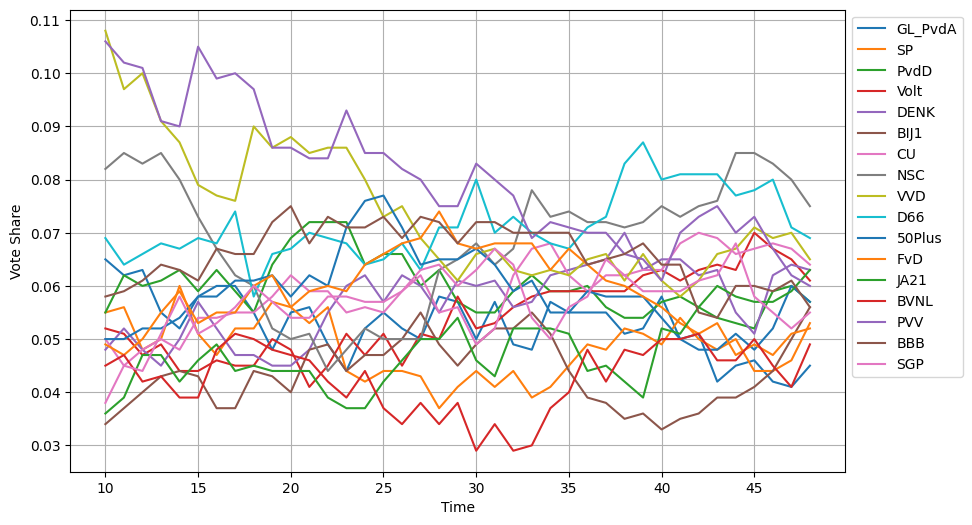

In [175]:
events: List[Dict[str, Any]] = [
    {"party": "VVD", "start": 5, "end": 10, "A": 2.0},
    {"party": "PVV", "start": 8, "end": 15, "A": 1.5}
]

parties_list, probs_2023, _, _ = dict_to_party_arrays(parties2023)

time_steps = 48

history = simulate_amb(
    N=1000,
    parties=parties_list,
    probs_2023=probs_2023,
    time_steps=time_steps,
    peer_pressure_strength=3,
    events_strength=1,
    bias_strength=1.0,
    perception_noise=0.12,
    assimilation_strength=0.30,
    graph_type="small_world",
    events=events,
    seed=2
)

plt.figure(figsize=(10, 6))
for i, party in enumerate(parties2023.keys()):
    plt.plot(range(10, time_steps + 1), history[10:, i], label=party)

plt.xlabel('Time')
plt.ylabel('Vote Share')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

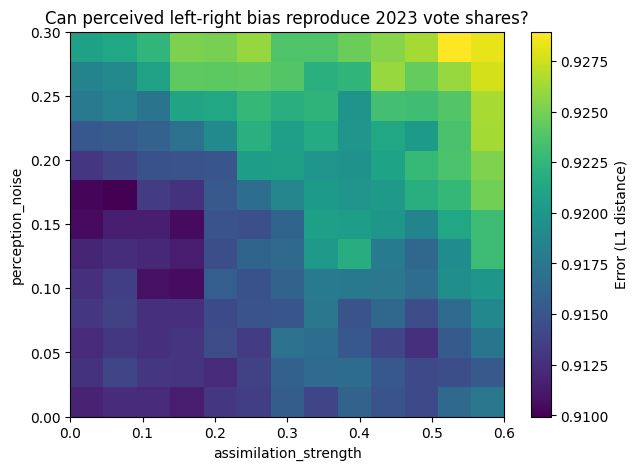

In [176]:
parties_list, probs_2023, _, _ = dict_to_party_arrays(parties2023)
target = probs_2023.copy()

def fit_error(sim_shares: np.ndarray, target: np.ndarray) -> float:
    # L1 distance
    return float(np.abs(sim_shares - target).sum())

perception_noise_grid = np.linspace(0.00, 0.30, 13)
assimilation_strength_grid = np.linspace(0.00, 0.60, 13)
E = np.zeros((len(perception_noise_grid), len(assimilation_strength_grid)))

common_kwargs = dict(
    N=5000,
    parties=parties_list,
    probs_2023=probs_2023,
    time_steps=48,
    peer_pressure_strength=0.0, # disable peer pressure
    events_strength=0.0, # disable events
    bias_strength=1.0,
    graph_type="small_world",
)

repeats = 5

for i, noise in enumerate(perception_noise_grid):
    for j, assim in enumerate(assimilation_strength_grid):
        errs = []
        for r in range(repeats):
            history = simulate_amb(
                **common_kwargs,
                perception_noise=float(noise),
                assimilation_strength=float(assim),
                seed=100 + r
            )
            sim_final = history[-1]
            errs.append(fit_error(sim_final, target))
        E[i, j] = np.mean(errs)

plt.figure(figsize=(7, 5))
plt.imshow(E, origin="lower", aspect="auto", extent=[assimilation_strength_grid[0], assimilation_strength_grid[-1], perception_noise_grid[0], perception_noise_grid[-1]])
plt.colorbar(label="Error (L1 distance)")
plt.xlabel("assimilation_strength")
plt.ylabel("perception_noise")
plt.title("Can perceived left-right bias reproduce 2023 vote shares?")
plt.show()


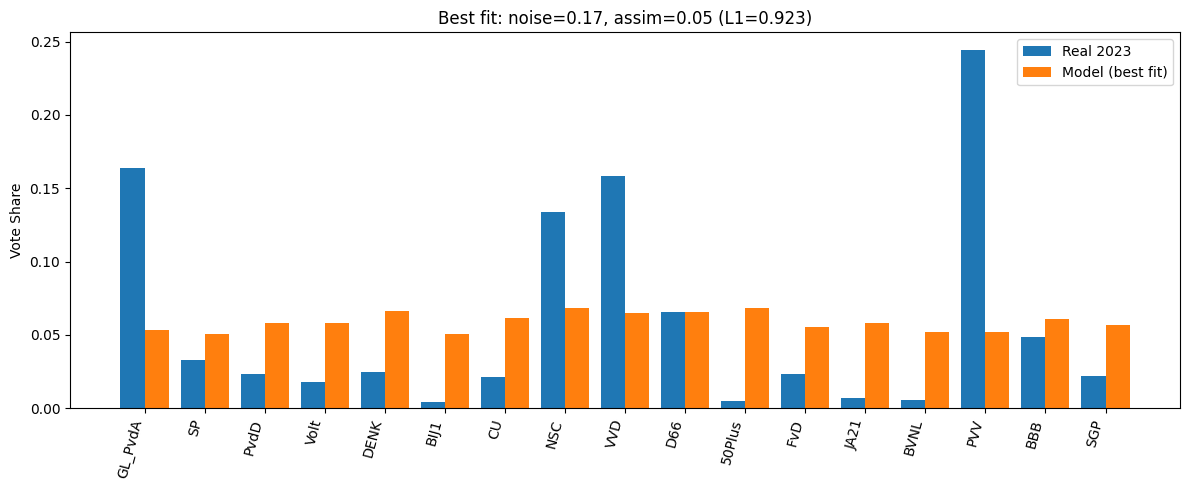

In [177]:
best_idx = np.unravel_index(np.argmin(E), E.shape)
best_noise = float(perception_noise_grid[best_idx[0]])
best_assim = float(assimilation_strength_grid[best_idx[1]])

history_best = simulate_amb(
    **common_kwargs,
    perception_noise=best_noise,
    assimilation_strength=best_assim,
    seed=999
)
sim_best = history_best[-1]

x = np.arange(len(parties_list))
plt.figure(figsize=(12, 5))
plt.bar(x - 0.2, target, width=0.4, label="Real 2023")
plt.bar(x + 0.2, sim_best, width=0.4, label="Model (best fit)")
plt.xticks(x, parties_list, rotation=75, ha="right")
plt.ylabel("Vote Share")
plt.title(f"Best fit: noise={best_noise:.2f}, assim={best_assim:.2f} (L1={fit_error(sim_best, target):.3f})")
plt.legend()
plt.tight_layout()
plt.show()


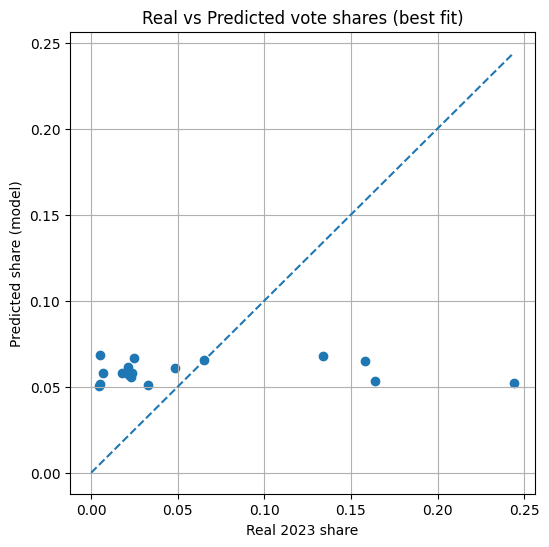

In [178]:
plt.figure(figsize=(6,6))
plt.scatter(target, sim_best)
plt.plot([0, max(target)], [0, max(target)], linestyle="--")
plt.xlabel("Real 2023 share")
plt.ylabel("Predicted share (model)")
plt.title("Real vs Predicted vote shares (best fit)")
plt.grid(True)
plt.show()


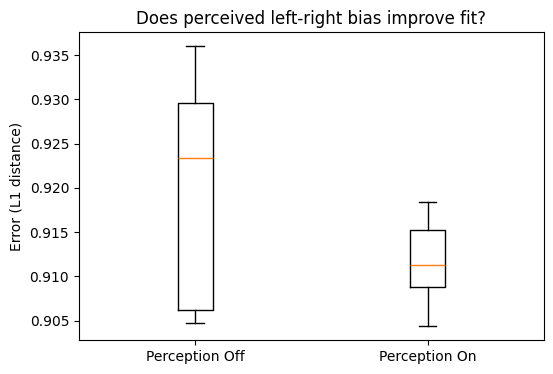

In [179]:
def run_err(noise, assim, seed):
    h = simulate_amb(**common_kwargs, perception_noise=noise, assimilation_strength=assim, seed=seed)
    return fit_error(h[-1], target)

errs_off = [run_err(0.0, 0.0, 200+r) for r in range(10)]
errs_on  = [run_err(best_noise, best_assim, 300+r) for r in range(10)]

plt.figure(figsize=(6,4))
plt.boxplot([errs_off, errs_on], tick_labels=["Perception Off", "Perception On"])
plt.ylabel("Error (L1 distance)")
plt.title("Does perceived left-right bias improve fit?")
plt.show()